In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score, precision_recall_curve, roc_curve
)

### 1) Open and read data from the provided file. 

In [3]:
df = pd.read_csv("data/data.csv")
df['model1_prob_class1'] = 1 - df['Model_1_0']
df['model2_prob_class1'] = df['Model_2_1']
df["actual"] = df["GT"]
df = df[["actual", "model1_prob_class1", "model2_prob_class1"]]

### 2) Determine the balance of the data set. Output the number of objects of each class.

In [4]:
class_counts = df["actual"].value_counts()
print("Class balance:")
print(class_counts)

Class balance:
actual
1    2200
0    2200
Name: count, dtype: int64


### 3.a) Calculate all metrics (Accuracy, Precision, Recall, F-Scores, Matthews Correlation Coefficient, Balanced Accuracy) for each model at different values ​​of the classifier threshold.

In [5]:
thresholds = np.linspace(0, 1, 21) 
print("Classifier thresholds: ", thresholds)

Classifier thresholds:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [6]:
def compute_metrics(actual, predicted):
    """ A function to calculate all the necessary metrics """
    return {
        "accuracy": accuracy_score(actual, predicted),
        "precision": precision_score(actual, predicted, zero_division=0),
        "recall": recall_score(actual, predicted),
        "f1": f1_score(actual, predicted),
        "mcc": matthews_corrcoef(actual, predicted),
        "balanced_accuracy": balanced_accuracy_score(actual, predicted)
    }

In [7]:
metrics_model1 = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': [], 'balanced_accuracy': []}
metrics_model2 = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': [], 'balanced_accuracy': []}

In [8]:
for t in thresholds:
    pred_model1 = (df['model1_prob_class1'] > t).astype(int)
    pred_model2 = (df['model2_prob_class1'] > t).astype(int)
    actual_class = df["actual"]

    # calculate metrics for both models
    metrics1 = compute_metrics(actual_class, pred_model1)
    metrics2 = compute_metrics(actual_class, pred_model2)

    # append the results
    metrics_model1["threshold"].append(t)
    metrics_model2["threshold"].append(t)

    for key in metrics1:
        metrics_model1[key].append(metrics1[key])
        metrics_model2[key].append(metrics2[key])

In [9]:
# convert to DataFrame
df_metrics1 = pd.DataFrame(metrics_model1)
df_metrics2 = pd.DataFrame(metrics_model2)

In [10]:
df_metrics1.head()

,threshold,accuracy,precision,recall,f1,mcc,balanced_accuracy
0,0.00,0.500000,0.500000,1.000000,0.666667,0.000000,0.500000
1,0.05,0.977955,0.958970,0.998636,0.978401,0.956728,0.977955
2,0.10,0.982955,0.968681,0.998182,0.983210,0.966357,0.982955
3,0.15,0.984773,0.972112,0.998182,0.984974,0.969894,0.984773
4,0.20,0.985682,0.975523,0.996364,0.985833,0.971585,0.985682


###  3.b) Plot on one graph in one coordinate system (threshold value; metric value) graphs of all calculated metrics, marking in a certain way the maximum value of each of them.

In [20]:
def plot_model_metrics(model_metrics_df, title):
    plt.figure(figsize=(12, 6))

    # go through all the metrics
    for column in model_metrics_df.columns[1:]:
        plt.plot(model_metrics_df["threshold"], model_metrics_df[column], label=column)

        # find the point with the maximum value
        max_idx = model_metrics_df[column].idxmax()
        plt.scatter(model_metrics_df["threshold"][max_idx], model_metrics_df[column][max_idx], marker="o")

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title(f"Metric values depending on the classification threshold ({title})")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

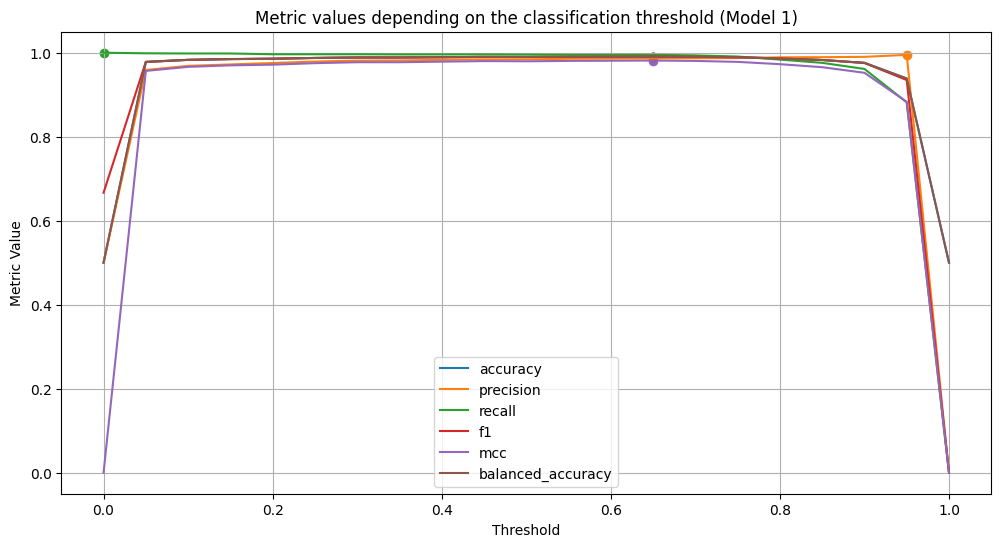

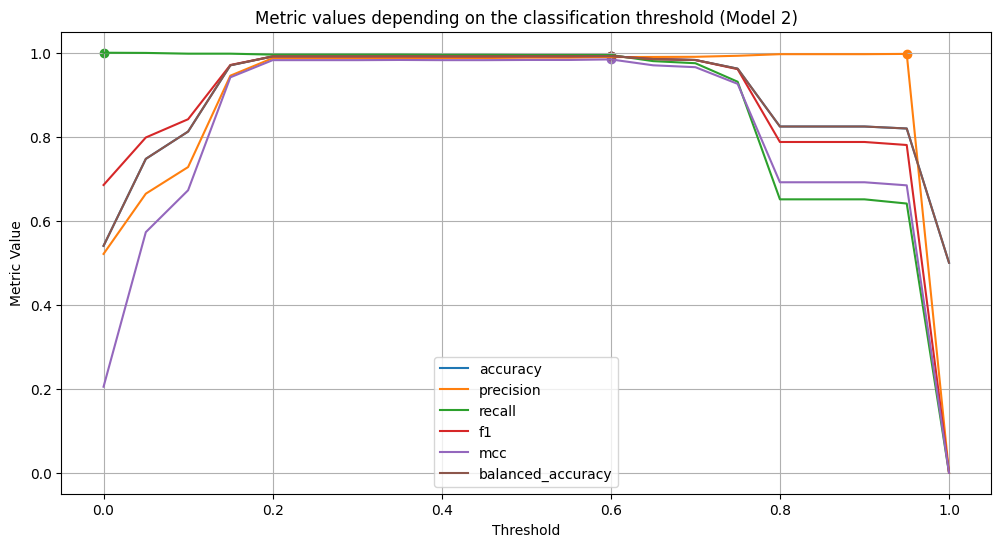

In [21]:
plot_model_metrics(df_metrics1, title="Model 1")
plot_model_metrics(df_metrics2, title="Model 2")

- At a threshold of 0.95, we have few False Positive errors and many False Negative errors, so precision is high and recall is low.
- At a threshold of 0, we classify everyone as class 1 - many False Positive errors and no False Negative errors, so recall is high and precision is low.

- At a threshold of 0.65 for the first model and 0.6 for the second model, the best values ​​of all other metrics are achieved.

###  3.c) Plot separate graphs of the number of objects for each class in coordinates (classifier score values; number of objects in each class) and mark the optimal cutoff thresholds for each metric with vertical lines. 

In [22]:
# Finding the optimal threshold for each metric
optimal_thresholds_model1 = {}
optimal_thresholds_model2 = {}

for column in df_metrics1.columns[1:]:
    max_idx = df_metrics1[column].idxmax() 
    optimal_thresholds_model1[column] = df_metrics1.loc[max_idx, "threshold"]

for column in df_metrics2.columns[1:]:
    max_idx = df_metrics2[column].idxmax() 
    optimal_thresholds_model2[column] = df_metrics2.loc[max_idx, "threshold"]

In [23]:
def plot_score_distribution(df, model_col, optimal_thresholds, title):
    """ Function to plot the scores distribution for a model with an optimal threshold for each metric marked"""
    
    plt.figure(figsize=(10, 6))
    plt.hist(df[df["actual"] == 0][model_col], bins=20, alpha=0.5, label="Class 0")
    plt.hist(df[df["actual"] == 1][model_col], bins=20, alpha=0.5, label="Class 1")

    threshold_positions = {}  # dictionary for unique label positions
    for i, (metric, threshold) in enumerate(optimal_thresholds.items()):
        plt.axvline(threshold, linestyle="--")

        # determine if there are already labels for this threshold
        if threshold in threshold_positions:
            threshold_positions[threshold] -= 0.05  # move below if there is already a label
        else:
            threshold_positions[threshold] = -0.1  # initial value under the graph

        # add text horizontally near the corresponding threshold
        plt.text(
            threshold, threshold_positions[threshold], metric,
            rotation=0, ha='center', va='top', fontsize=10, transform=plt.gca().transAxes
        )

    plt.xlabel("Classifier score")
    plt.ylabel("Number of objects")
    plt.title(f"Classifier score distribution {title}")
    plt.show()

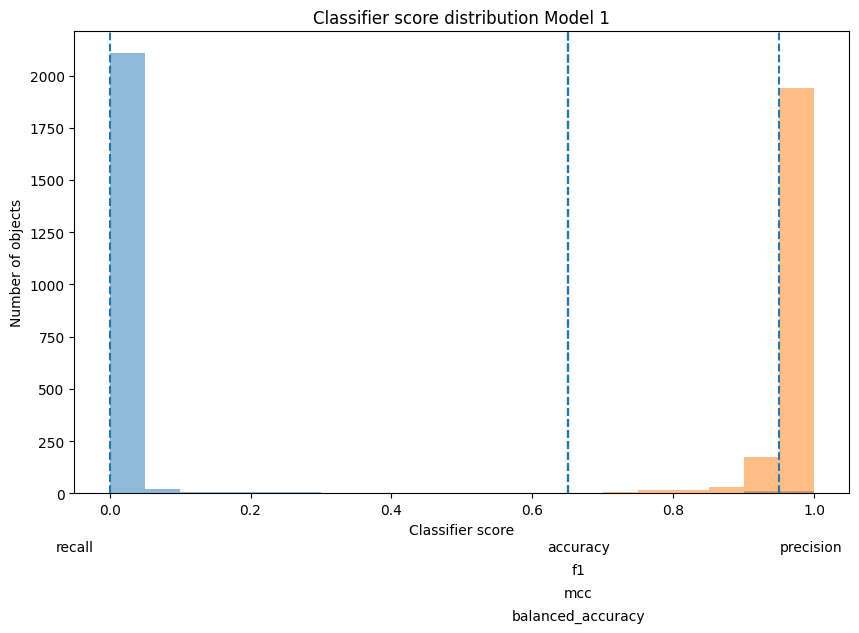

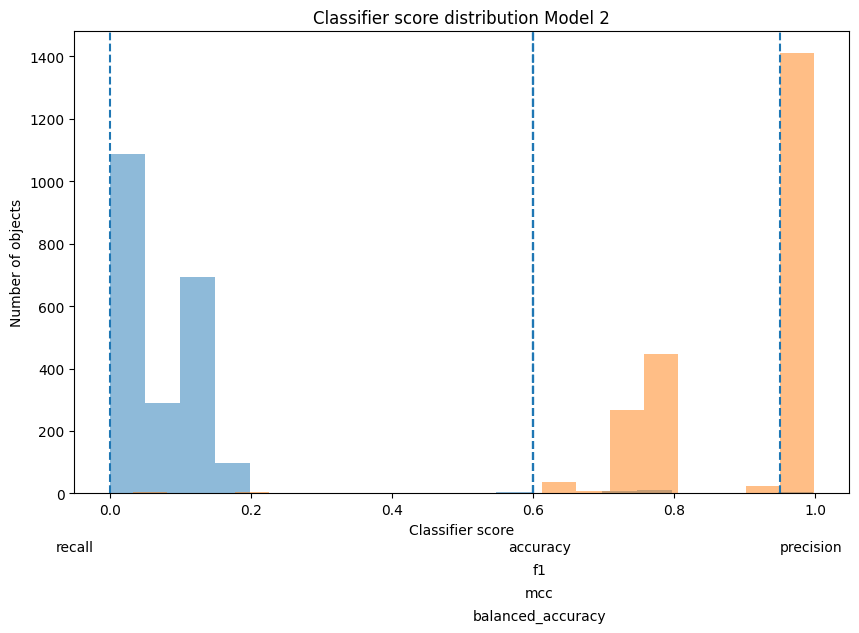

In [24]:
plot_score_distribution(df, "model1_prob_class1", optimal_thresholds_model1, "Model 1")
plot_score_distribution(df, "model2_prob_class1", optimal_thresholds_model2, "Model 2")

#### We can see that the first model determines the probabilities of belonging to a particular class more confidently than the second model.

### 3.d) Plot a PR curve and ROC curve for each classifier.

In [25]:
def plot_pr_roc_curves(df, model_pred, model_name):
    actual_class = df["actual"]

    precision, recall, _ = precision_recall_curve(actual_class, df[model_pred])
    fpr, tpr, _ = roc_curve(actual_class, df[model_pred])
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR-curve for {model_name}")
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-curve for {model_name}")
    
    plt.show()

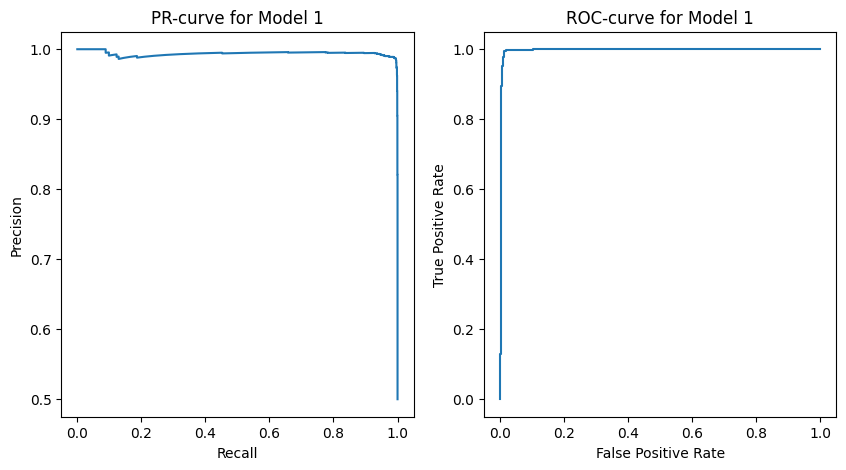

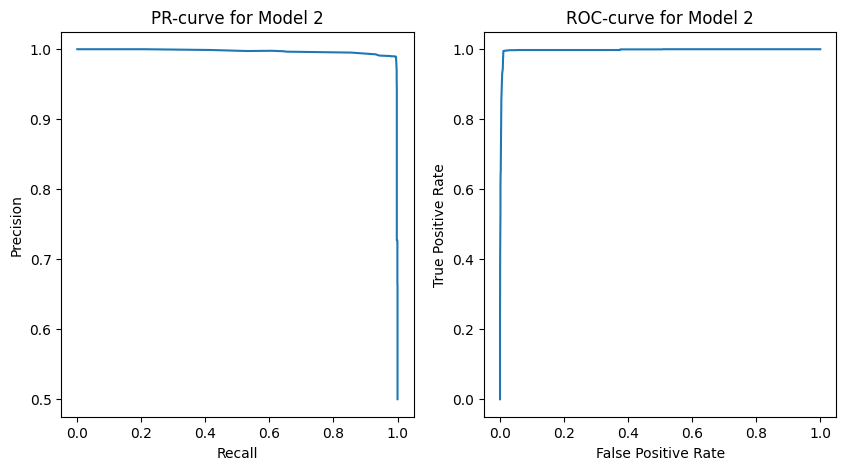

In [26]:
plot_pr_roc_curves(df, "model1_prob_class1", "Model 1")
plot_pr_roc_curves(df, "model2_prob_class1", "Model 2")

#### As we can see, the areas under the PR and ROC curves of the second model are slightly larger than the areas under the corresponding curves of the first model.

### 4) Draw conclusions about the quality of the models, determine the best model.

#### Let's look at the metrics of the first classifier at the optimal threshold (0.65)

In [ ]:
df_metrics1.iloc[13, :]

threshold            0.650000
accuracy             0.990682
precision            0.986480
recall               0.995000
f1                   0.990722
mcc                  0.981400
balanced_accuracy    0.990682
Name: 13, dtype: float64

#### Let's look at the metrics of the second classifier at the optimal threshold (0.6)

In [33]:
df_metrics2.iloc[12, :]

threshold            0.600000
accuracy             0.992045
precision            0.989597
recall               0.994545
f1                   0.992065
mcc                  0.984103
balanced_accuracy    0.992045
Name: 12, dtype: float64

#### Conclusion: Model 1 achieves the best results at a threshold of 0.65, model 2 at a threshold of 0.6. Both models show very good results, however, model 2 has slightly better metrics at the optimal threshold. Thus, model 2 can be considered better.

### 5) Create a new data set by removing (50 + 10K)% of class 1 objects, selected randomly, from the initial set.

In [27]:
def create_imbalanced_dataset(df, birth_date):
    """ Function to create a new unbalanced dataset"""    
    month = int(birth_date.split('-')[1])
    K = month % 4
    reduction_percentage = 50 + 10 * K 
    remove_class_1_count = int(2200 * (reduction_percentage / 100))

    df_class_1 = df[df['actual'] == 1] 
    class_1_indices = df_class_1.sample(n=remove_class_1_count, random_state=1).index

    df_imbalanced = df.drop(index=class_1_indices).reset_index(drop=True)
    return df_imbalanced

In [28]:
df_new = create_imbalanced_dataset(df, '05-11')

### 6) Output the percentage of class 1 objects removed and the number of elements of each class after removal.

In [29]:
class_counts = df_new["actual"].value_counts()
print(f"Percentage of class 1 objects removed: {50 + 10 * (11 % 4)}%")
print("Class balance:")
print(class_counts)

Percentage of class 1 objects removed: 80%
Class balance:
actual
0    2200
1     440
Name: count, dtype: int64


### 7) Perform the steps from step 3 for the new data set.

In [30]:
metrics_model1_new = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': [], 'balanced_accuracy': []}
metrics_model2_new = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'mcc': [], 'balanced_accuracy': []}

In [31]:
for t in thresholds:
    pred_model1 = (df_new['model1_prob_class1'] > t).astype(int)
    pred_model2 = (df_new['model2_prob_class1'] > t).astype(int)
    actual_class = df_new["actual"]

    # calculate metrics for both models
    metrics1 = compute_metrics(actual_class, pred_model1)
    metrics2 = compute_metrics(actual_class, pred_model2)

    # append the results
    metrics_model1_new["threshold"].append(t)
    metrics_model2_new["threshold"].append(t)

    for key in metrics1:
        metrics_model1_new[key].append(metrics1[key])
        metrics_model2_new[key].append(metrics2[key])

In [32]:
# convert to DataFrame
df_metrics1_new = pd.DataFrame(metrics_model1_new)
df_metrics2_new = pd.DataFrame(metrics_model2_new)

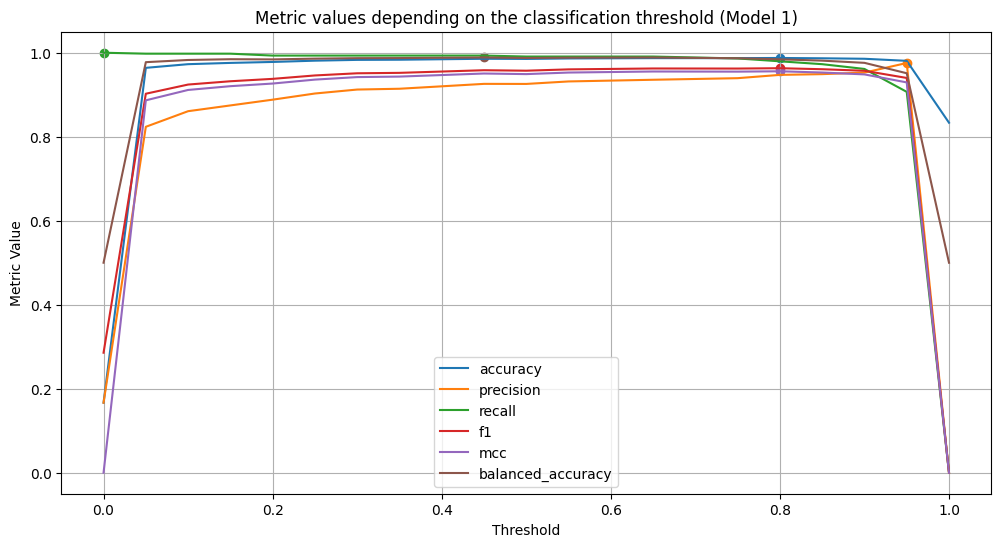

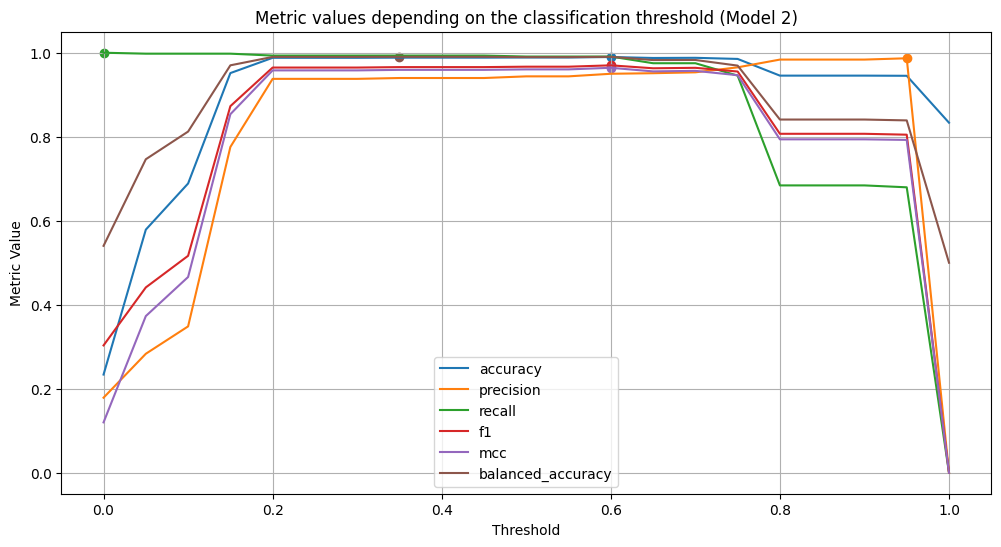

In [33]:
plot_model_metrics(df_metrics1_new, title="Model 1")
plot_model_metrics(df_metrics2_new, title="Model 2")

#### As we can see, all metrics except balanced accuracy achieve the best result at a threshold of 0.8 (0.6 for the second model), when the model is less likely to make mistakes with the large class (class 0). Balanced accuracy achieves the best result at a threshold of 0.45 (0.35 for the second model), when the model tries not to miss the small class (class 1). So, for unbalanced data, balanced accuracy gives the best result at lower thresholds, because it tries to maintain a balance between both classes.

In [34]:
# Finding the optimal threshold for each metric
optimal_thresholds_model1 = {}
optimal_thresholds_model2 = {}

for col in df_metrics1_new.columns[1:]:
    max_idx = df_metrics1_new[col].idxmax() 
    optimal_thresholds_model1[col] = df_metrics1_new.loc[max_idx, "threshold"]

for col in df_metrics2_new.columns[1:]:
    max_idx = df_metrics2_new[col].idxmax() 
    optimal_thresholds_model2[col] = df_metrics2_new.loc[max_idx, "threshold"]

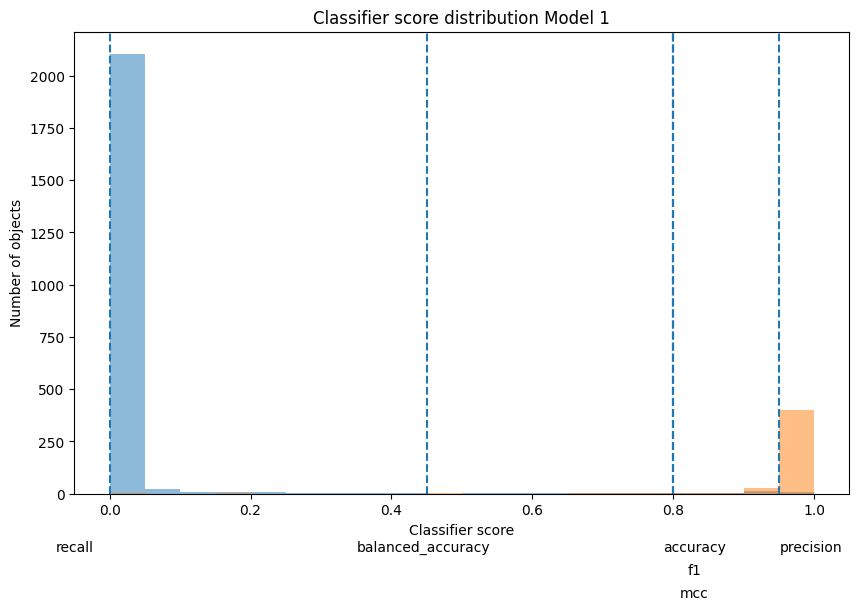

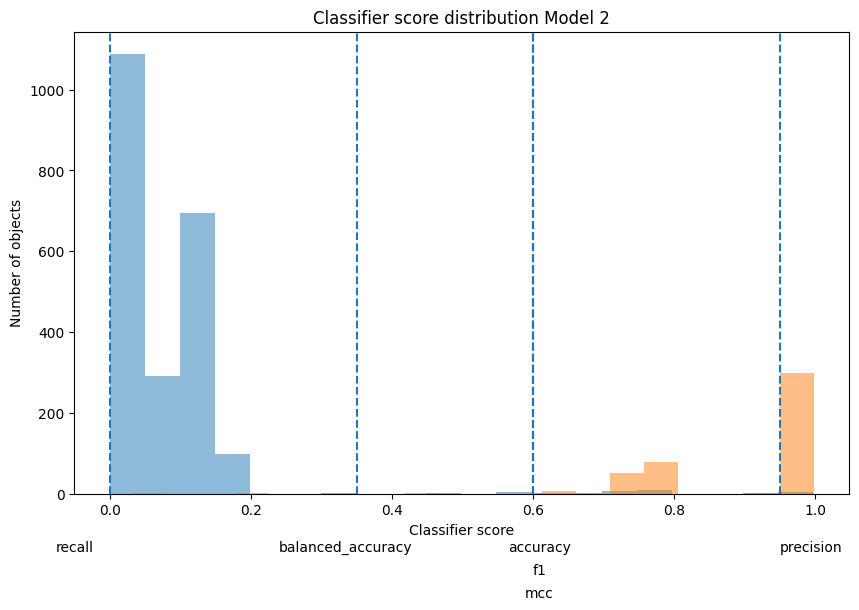

In [36]:
plot_score_distribution(df_new, "model1_prob_class1", optimal_thresholds_model1, "Model 1")
plot_score_distribution(df_new, "model2_prob_class1", optimal_thresholds_model2, "Model 2")

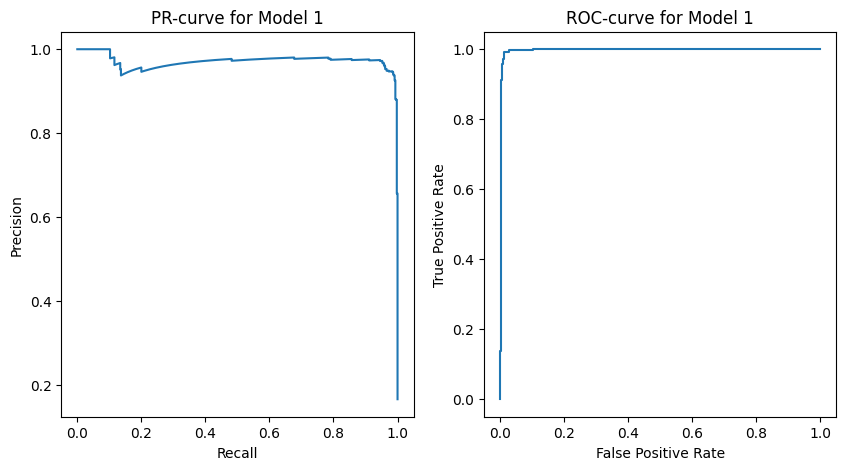

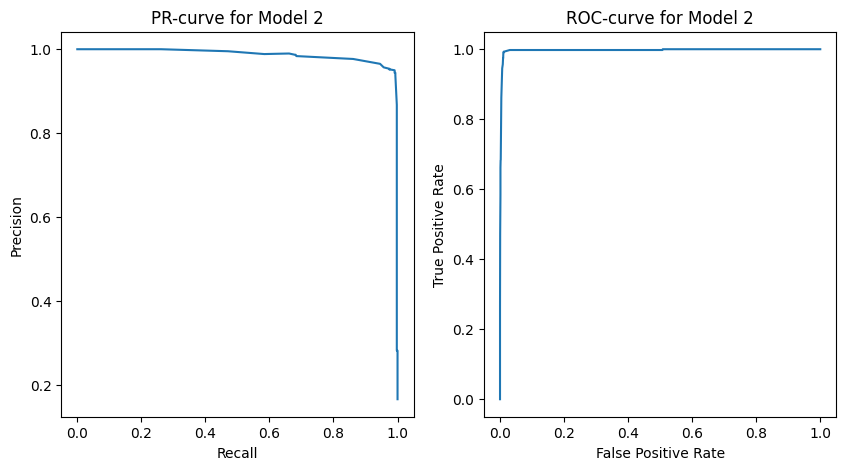

In [37]:
plot_pr_roc_curves(df_new, "model1_prob_class1", "Model 1")
plot_pr_roc_curves(df_new, "model2_prob_class1", "Model 2")

#### As we can see, the areas under the PR and ROC curves of the second model are slightly larger than the areas under the corresponding curves of the first model.

#### Let's look at the metrics of the first classifier at the optimal threshold (0.45)

In [38]:
df_metrics1_new.iloc[9, :]

threshold            0.450000
accuracy             0.985606
precision            0.925847
recall               0.993182
f1                   0.958333
mcc                  0.950502
balanced_accuracy    0.988636
Name: 9, dtype: float64

#### Let's look at the metrics of the second classifier at the optimal threshold (0.35)

In [39]:
df_metrics2_new.iloc[7, :]

threshold            0.350000
accuracy             0.988258
precision            0.939785
recall               0.993182
f1                   0.965746
mcc                  0.959200
balanced_accuracy    0.990227
Name: 7, dtype: float64

### Conclusion: Model 1 achieves the best results in terms of balanced_accuracy metrics at a threshold of 0.45, model 2 at a threshold of 0.35. Both models demonstrate very good results, but model 2 has slightly better performance at the optimal threshold. Thus, model 2 can be considered better.